In [1]:
import torch
from PIL import Image
from lavis.models import load_model_and_preprocess

/opt/conda/lib/python3.8/site-packages/diffusers/models/cross_attention.py:30: FutureWarning: Importing from cross_attention is deprecated. Please import from diffusers.models.attention_processor instead.
  deprecate(


In [2]:
torch.cuda.is_available()

True

In [3]:
model, vis_preprocess, txt_preprocess = load_model_and_preprocess("blip_diffusion", "base", device="cuda", is_eval=True)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/opt/conda/lib/python3.8/site-packages/diffusers/configuration_utils.py:215: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality

No ctx_embeddings_cache found in /root/.cache/torch/hub/checkpoints/blip-diffusion


### Description
This demo shows how to zero-shot edit a **real** image, in a virtual try-on application. It works in the following steps:

(1) run DDIM inversion on the ``src_image`` using prompt ``A ${src_subject} ${prompt}.``; the ``src_subject`` can be a noun for the outfit, e.g. dress, shirt, jacket, depending on the ``src_image``.

(2) extracting BLIP-2 embeddings on condition subject image, using ``cond_subject`` and ``cond_image``. The condition image can be a different outfit/clothes to try on.

(3) edit the real image with the subject visuals, using the prompt ``A ${BLIP-2 embedding} ${tgt_subject} ${prompt}`` and the DDIM inverted latents.

### Tips

(1) Best results are obtained if the shapes of the clothing in the conditional image and the source image are similar.

(2) Try different ``lb_threshold`` to adjust the area of the edited regions.

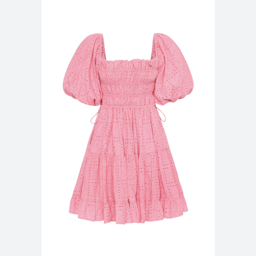

In [4]:
cond_subject = "dress"
src_subject = "dress"
tgt_subject = "dress"

text_prompt = "on a model"

src_subject = txt_preprocess["eval"](src_subject)
tgt_subject = txt_preprocess["eval"](tgt_subject)
cond_subject = txt_preprocess["eval"](cond_subject)
text_prompt = [txt_preprocess["eval"](text_prompt)]

cond_image = Image.open("../images/pink-dress.png").convert("RGB")
display(cond_image.resize((256, 256)))
cond_image = vis_preprocess["eval"](cond_image).unsqueeze(0).cuda()

src_image = Image.open("../images/dress-model.png").convert("RGB")

In [5]:
samples = {
    "cond_images": cond_image,
    "cond_subject": cond_subject,
    "src_subject": src_subject,
    "tgt_subject": tgt_subject,
    "prompt": text_prompt,
    "raw_image": src_image,
}

/export/home/workspace/LAVIS-Diffusion/LAVIS/lavis/models/blip_diffusion_models/blip_diffusion.py:331: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  self.unet.in_channels,
/opt/conda/lib/python3.8/site-packages/diffusers/configuration_utils.py:215: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddim.DDIMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
100%|██████████| 50/50 [00:03<00:00, 16.16it/s]


['a dress on a model', 'a sks sks sks sks sks sks sks sks sks sks sks sks sks sks sks sks dress on a model']


100%|██████████| 50/50 [00:09<00:00,  5.30it/s]


Before editing:


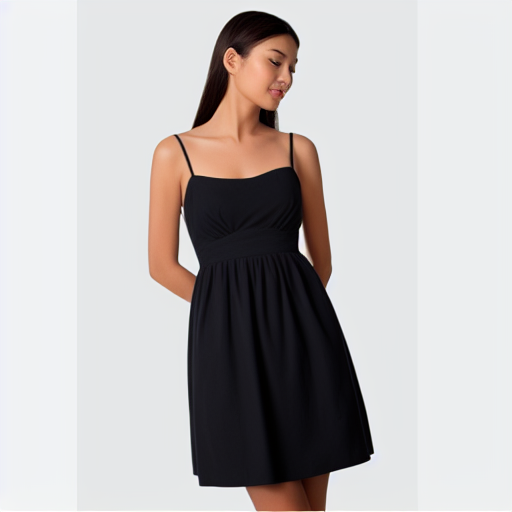

After editing:


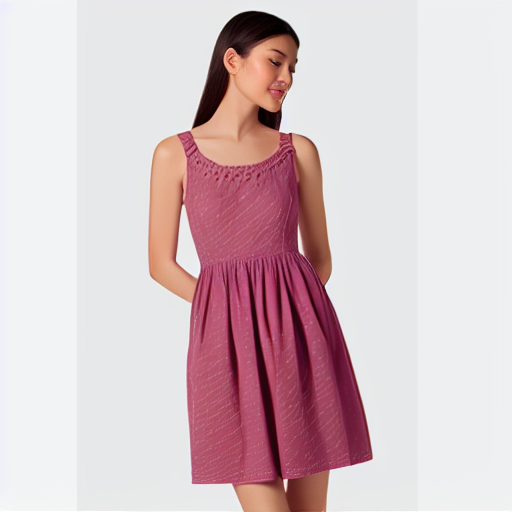

In [6]:
iter_seed = 88871
guidance_scale = 7.5
num_inference_steps = 50
num_inversion_steps = 50 # increase to improve DDIM inversion quality
lb_threshold = 0.15 # ncrease to edit fewer pixels.
negative_prompt = "over-exposure, under-exposure, saturated, duplicate, out of frame, lowres, cropped, worst quality, low quality, jpeg artifacts, morbid, mutilated, out of frame, ugly, bad anatomy, bad proportions, deformed, blurry, duplicate"

output = model.edit(
    samples,
    seed=iter_seed,
    guidance_scale=guidance_scale,
    num_inference_steps=num_inference_steps,
    num_inversion_steps=num_inversion_steps,
    neg_prompt=negative_prompt,
    lb_threshold=lb_threshold,
)

print("=" * 30)
print("Before editing:")
display(output[0])

print("After editing:")
display(output[1])

In [7]:
output[0].size

(512, 512)